# Classification Lab: Wine Quality Classification

## Overview

In this lab, we extend the regression lab to classification. Using the same wine dataset, we'll build classifiers to predict quality categories rather than exact ratings.

**Dataset**: Wine Quality (UCI ML Repository) - Same as regression lab
- **Samples**: ~1,600 red wine samples
- **Features**: 11 physicochemical properties
- **Target**: Quality rating (3-8) → classification labels

**Lab Structure**:
- **Part A**: Binary classification (quality ≥ 7 vs < 7)
- **Part B**: Multiclass classification (all quality levels 3-8)
- **Part C**: Algorithm comparison (KNN, LDA, Naive Bayes)

**Note**: This lab assumes you've completed the regression lab. We reuse the same preprocessing patterns (train/test split, pipelines, scaling) but focus on classification-specific concepts (probabilities, decision thresholds, class imbalance).

## Setup: Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load wine quality dataset (same as regression lab)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")

print(f"Dataset shape: {df.shape}")
print(f"Features: {list(df.columns[:-1])}")
print(f"Quality range: {df['quality'].min()}-{df['quality'].max()}")

Dataset shape: (1599, 12)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Quality range: 3-8


## Part A: Binary Classification

**Task**: Classify wines as "good" (quality ≥ 7) vs "not good" (quality < 7)

This is similar to logistic regression but now produces probabilities for each class.

In [4]:
# Prepare features
X = df.drop('quality', axis=1)
y = df['quality']

# TODO: Create binary target
# Hint: Create a binary variable where y_binary = 1 if quality >= 7, else 0
y_binary = (y >= 7).astype(int)

# Analyze class distribution
print("Binary Classification Target Distribution:")
print(f"  Not Good (< 7): {(y_binary == 0).sum()} samples ({(y_binary == 0).sum() / len(y_binary) * 100:.1f}%)")
print(f"  Good (≥ 7):     {(y_binary == 1).sum()} samples ({(y_binary == 1).sum() / len(y_binary) * 100:.1f}%)")
print(f"\nClass imbalance ratio: {(y_binary == 0).sum() / (y_binary == 1).sum():.2f}:1")

Binary Classification Target Distribution:
  Not Good (< 7): 1382 samples (86.4%)
  Good (≥ 7):     217 samples (13.6%)

Class imbalance ratio: 6.37:1


In [5]:
# TODO: Split data into train/test sets with 80/20 split and random_state=42
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1279 samples, 11 features
Test set: 320 samples


### A.1: Why Linear Regression Fails for Classification

Unlike regression which predicts continuous values, classification needs **probabilities** (between 0 and 1). Linear regression can produce values outside [0, 1], which don't make sense for binary classification.

In [6]:
# Demo: Show that linear regression produces invalid probabilities
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_preds = linear_model.predict(X_test)

print("Linear Regression Predictions (problematic for classification):")
print(f"  Min: {linear_preds.min():.4f}")
print(f"  Max: {linear_preds.max():.4f}")
print(f"  Mean: {linear_preds.mean():.4f}")
print(f"\nProblem: Predictions outside [0, 1]!")
print(f"  Values < 0: {(linear_preds < 0).sum()} samples")
print(f"  Values > 1: {(linear_preds > 1).sum()} samples")
print(f"\nSolution: Use logistic regression with sigmoid function to map to [0, 1].")

Linear Regression Predictions (problematic for classification):
  Min: -0.1868
  Max: 0.5629
  Mean: 0.1224

Problem: Predictions outside [0, 1]!
  Values < 0: 85 samples
  Values > 1: 0 samples

Solution: Use logistic regression with sigmoid function to map to [0, 1].


### A.2: Logistic Regression Pipeline

Logistic regression uses the **sigmoid function** σ(z) = 1/(1 + e^(-z)) to map predictions to [0, 1], interpreted as P(Y=1|X).

In [ ]:
# TODO: Create a Pipeline with StandardScaler and LogisticRegression
pipeline_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(random_state=42, max_iter=1000))
])

# Fit on training data
pipeline_logistic.fit(X_train, y_train)

# Make predictions
y_pred_binary = pipeline_logistic.predict(X_test)
accuracy_binary = accuracy_score(y_test, y_pred_binary)

print(f"Binary Logistic Regression - Test Accuracy: {accuracy_binary:.4f}")
print(f"\nPredictions (0 = Not Good, 1 = Good):")
print(f"  Class 0: {(y_pred_binary == 0).sum()} predictions")
print(f"  Class 1: {(y_pred_binary == 1).sum()} predictions")

Binary Logistic Regression - Test Accuracy: 0.8938

Predictions (0 = Not Good, 1 = Good):
  Class 0: 297 predictions
  Class 1: 23 predictions


### A.3: Probability Predictions

The power of logistic regression: access to **predicted probabilities** before converting to class labels.

In [8]:
# Demo: Extract probability predictions
y_proba = pipeline_logistic.predict_proba(X_test)

print(f"Probability predictions shape: {y_proba.shape}")
print(f"Classes: {pipeline_logistic.classes_}")
print(f"\nFirst 10 samples:")
print(f"  P(Not Good)  |  P(Good)  |  Predicted Class")
print("-" * 50)
for i in range(10):
    print(f"  {y_proba[i, 0]:.4f}      |  {y_proba[i, 1]:.4f}   |  {y_pred_binary[i]} (actual: {y_test.iloc[i]})")

print(f"\nKey insight: Probabilities sum to 1 for each sample.")
print(f"  E.g., sample 0: {y_proba[0, 0]:.4f} + {y_proba[0, 1]:.4f} = {y_proba[0, :].sum():.4f}")

Probability predictions shape: (320, 2)
Classes: [0 1]

First 10 samples:
  P(Not Good)  |  P(Good)  |  Predicted Class
--------------------------------------------------
  0.8604      |  0.1396   |  0 (actual: 0)
  0.9807      |  0.0193   |  0 (actual: 0)
  0.9746      |  0.0254   |  0 (actual: 0)
  0.9778      |  0.0222   |  0 (actual: 0)
  0.9915      |  0.0085   |  0 (actual: 0)
  0.7211      |  0.2789   |  0 (actual: 0)
  0.8487      |  0.1513   |  0 (actual: 0)
  0.9202      |  0.0798   |  0 (actual: 0)
  0.9929      |  0.0071   |  0 (actual: 0)
  0.9783      |  0.0217   |  0 (actual: 0)

Key insight: Probabilities sum to 1 for each sample.
  E.g., sample 0: 0.8604 + 0.1396 = 1.0000


### A.4: Classification Metrics

Unlike regression (MSE, R²), classification uses: **Accuracy, Precision, Recall, F1-score, Confusion Matrix**.

Confusion Matrix (Binary Classification):
[[270   7]
 [ 27  16]]

Binary Classification Metrics:
  Accuracy:  0.8938 (of all predictions, how many correct?)
  Precision: 0.6957 (of predicted 'Good', how many are actually Good?)
  Recall:    0.3721 (of actual 'Good', how many did we find?)
  F1-Score:  0.4848 (harmonic mean of precision & recall)


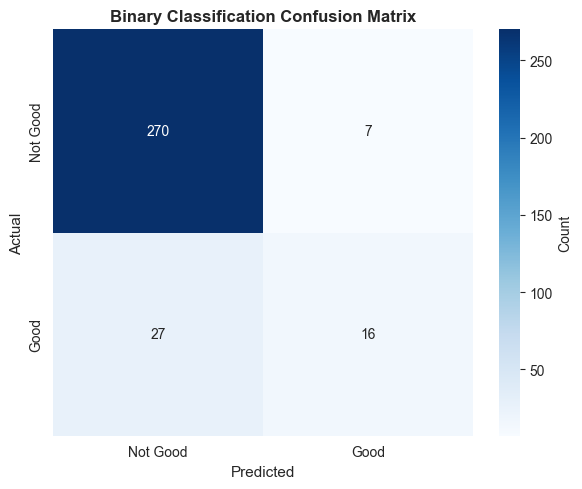

In [10]:
# TODO: Compute confusion matrix for binary classification
cm_binary = confusion_matrix(y_test, y_pred_binary)

print("Confusion Matrix (Binary Classification):")
print(cm_binary)
print()

# TODO: Compute binary classification metrics
acc = accuracy_score(y_test, y_pred_binary)
prec = precision_score(y_test, y_pred_binary)
rec = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Binary Classification Metrics:")
print(f"  Accuracy:  {acc:.4f} (of all predictions, how many correct?)")
print(f"  Precision: {prec:.4f} (of predicted 'Good', how many are actually Good?)")
print(f"  Recall:    {rec:.4f} (of actual 'Good', how many did we find?)")
print(f"  F1-Score:  {f1:.4f} (harmonic mean of precision & recall)")

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Good', 'Good'],
            yticklabels=['Not Good', 'Good'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_ylabel('Actual', fontsize=11)
ax.set_xlabel('Predicted', fontsize=11)
ax.set_title('Binary Classification Confusion Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### A.5: Decision Threshold

By default, we use threshold = 0.5 (P(Good) > 0.5 → predict Good). But this can be adjusted based on the cost of false positives vs false negatives.

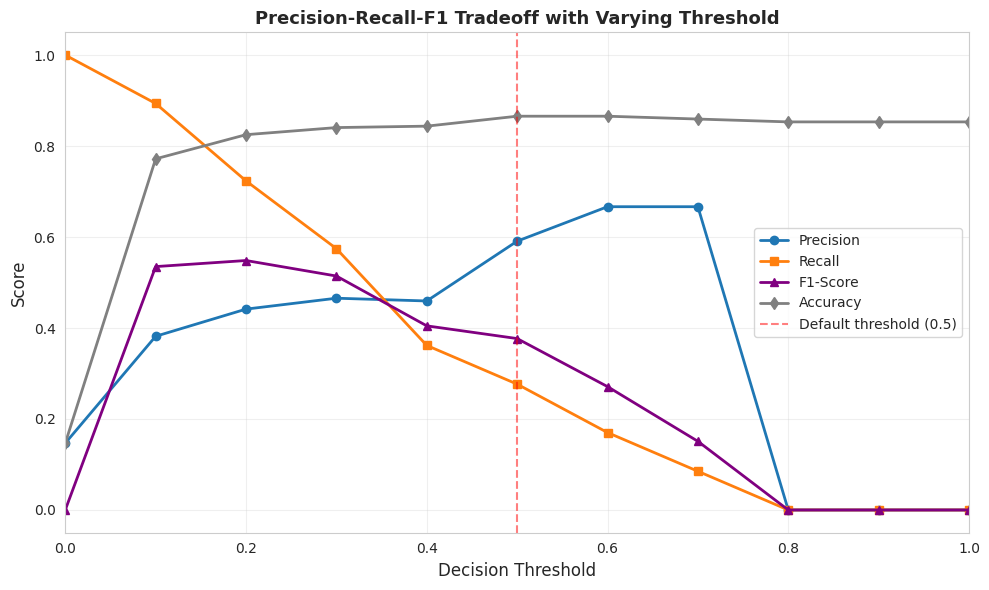

Key insight: Lower threshold → more 'Good' predictions → higher recall, lower precision.
              F1-score balances both: maximized around threshold = 0.2


In [ ]:
# Demo: Show precision-recall tradeoff by varying threshold
thresholds = np.arange(0.0, 1.01, 0.1)
precisions = []
recalls = []
f1_scores = []
accuracies = []

for threshold in thresholds:
    y_pred_thresh = (y_proba[:, 1] >= threshold).astype(int)
    
    # Handle edge cases where one class is missing
    if len(np.unique(y_pred_thresh)) == 1:
        prec = 0 if np.unique(y_pred_thresh)[0] == 0 else accuracy_score(y_test, y_pred_thresh)
        rec = 0 if np.unique(y_pred_thresh)[0] == 0 else 1.0
        f1 = 0
    else:
        prec = precision_score(y_test, y_pred_thresh)
        rec = recall_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)
    
    acc = accuracy_score(y_test, y_pred_thresh)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    accuracies.append(acc)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, precisions, marker='o', label='Precision', linewidth=2)
ax.plot(thresholds, recalls, marker='s', label='Recall', linewidth=2)
ax.plot(thresholds, f1_scores, marker='^', label='F1-Score', linewidth=2, color='purple')
ax.plot(thresholds, accuracies, marker='d', label='Accuracy', linewidth=2, color='gray')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default threshold (0.5)')

ax.set_xlabel('Decision Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision-Recall-F1 Tradeoff with Varying Threshold', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

print("Key insight: Lower threshold → more 'Good' predictions → higher recall, lower precision.")
print(f"              F1-score balances both: maximized around threshold = {thresholds[np.argmax(f1_scores)]:.1f}")

## Part B: Multiclass Classification

**Task**: Classify wines into all 10 quality levels (3-8, though some sparse)

This demonstrates **softmax** regression and handling class imbalance.

Multiclass Target Distribution (Original Quality Ratings):
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

Total classes: 6
Class imbalance: 681 (quality 6) vs 10 (quality 3)
Imbalance ratio: 68.1:1

         Metrics for these classes may be unreliable.


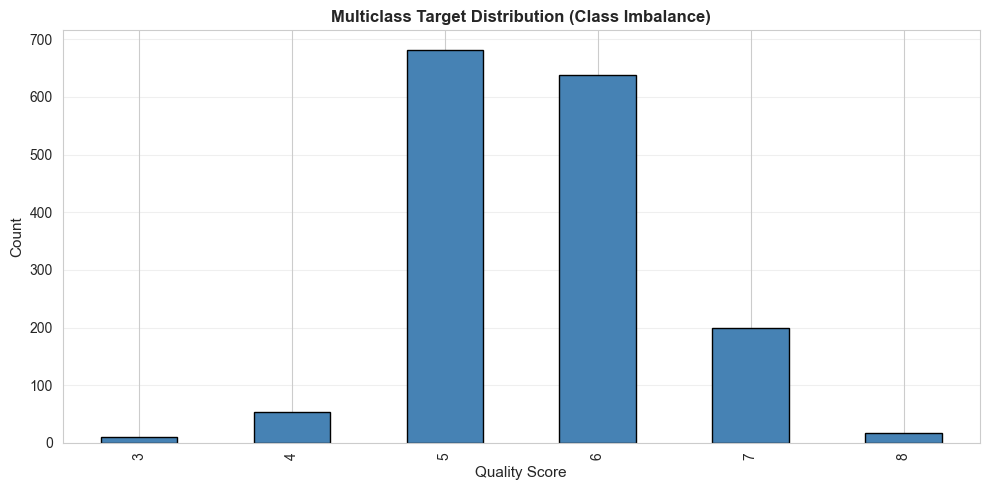

In [11]:
# Demo: Show quality distribution (our multiclass target)
quality_dist = df['quality'].value_counts().sort_index()

print("Multiclass Target Distribution (Original Quality Ratings):")
print(quality_dist)
print(f"\nTotal classes: {len(quality_dist)}")
print(f"Class imbalance: {quality_dist.max()} (quality 6) vs {quality_dist.min()} (quality 3)")
print(f"Imbalance ratio: {quality_dist.max() / quality_dist.min():.1f}:1")
print(f"\nWarning: Sparse classes (quality 3, 4) have very few samples.")
print(f"         Metrics for these classes may be unreliable.")

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
quality_dist.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Quality Score', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Multiclass Target Distribution (Class Imbalance)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Demo: Show softmax transformation from logits to probabilities
# Softmax(z)_i = exp(z_i) / sum(exp(z_j)) for all j

# Example with 5 classes
example_logits = np.array([2.0, -1.0, 0.5, 1.5, -0.3])

# Compute softmax
exp_logits = np.exp(example_logits)
softmax_probs = exp_logits / np.sum(exp_logits)

print("Softmax Transformation Example:")
print(f"  Raw logits:    {example_logits}")
print(f"  Exp(logits):   {exp_logits}")
print(f"  Softmax probs: {softmax_probs}")
print(f"  Sum of probs:  {softmax_probs.sum():.4f} (should be 1.0)")
print(f"\nFor 10 quality classes, logistic regression produces 10 logits.")
print(f"Softmax converts them to 10 probabilities that sum to 1.")

Softmax Transformation Example:
  Raw logits:    [ 2.  -1.   0.5  1.5 -0.3]
  Exp(logits):   [7.3890561  0.36787944 1.64872127 4.48168907 0.74081822]
  Softmax probs: [0.50512532 0.02514871 0.11270869 0.30637399 0.05064328]
  Sum of probs:  1.0000 (should be 1.0)

For 10 quality classes, logistic regression produces 10 logits.
Softmax converts them to 10 probabilities that sum to 1.


In [13]:
# Prepare multiclass targets
y_multiclass = df['quality']

# Train-test split (reuse same split for consistency)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42
)

print(f"Multiclass training set: {X_train_multi.shape[0]} samples, {X_train_multi.shape[1]} features")
print(f"Classes: {sorted(y_train_multi.unique())}")
print(f"\nClass distribution in training set:")
for cls in sorted(y_train_multi.unique()):
    count = (y_train_multi == cls).sum()
    pct = count / len(y_train_multi) * 100
    print(f"  Quality {cls}: {count:>3d} samples ({pct:>5.1f}%)")

Multiclass training set: 1279 samples, 11 features
Classes: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

Class distribution in training set:
  Quality 3:   9 samples (  0.7%)
  Quality 4:  43 samples (  3.4%)
  Quality 5: 551 samples ( 43.1%)
  Quality 6: 506 samples ( 39.6%)
  Quality 7: 157 samples ( 12.3%)
  Quality 8:  13 samples (  1.0%)


In [14]:
# Demo: Train multinomial logistic regression
pipeline_multiclass = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(
        random_state=42,
        max_iter=1000
    ))
])

pipeline_multiclass.fit(X_train_multi, y_train_multi)

y_pred_multi = pipeline_multiclass.predict(X_test_multi)
acc_multi = accuracy_score(y_test_multi, y_pred_multi)

print(f"Multinomial Logistic Regression - Test Accuracy: {acc_multi:.4f}")
print(f"\nPredictions distribution:")
for cls in sorted(np.unique(y_pred_multi)):
    count = (y_pred_multi == cls).sum()
    print(f"  Class {cls}: {count:>3d} predictions")

Multinomial Logistic Regression - Test Accuracy: 0.5750

Predictions distribution:
  Class 4:   1 predictions
  Class 5: 155 predictions
  Class 6: 141 predictions
  Class 7:  23 predictions


In [15]:
# Demo: Show multiclass probability predictions
y_proba_multi = pipeline_multiclass.predict_proba(X_test_multi)

print(f"Multiclass probability shape: {y_proba_multi.shape}")
print(f"Classes: {pipeline_multiclass.classes_}")
print(f"\nFirst sample:")
print(f"  Predicted class: {y_pred_multi[0]} (actual: {y_test_multi.iloc[0]})")
print(f"\n  Class probabilities:")
for i, cls in enumerate(pipeline_multiclass.classes_):
    print(f"    P(Quality={cls}): {y_proba_multi[0, i]:.4f}")
print(f"\n  Top 3 predictions:")
top_3_idx = np.argsort(y_proba_multi[0])[::-1][:3]
for rank, idx in enumerate(top_3_idx, 1):
    cls = pipeline_multiclass.classes_[idx]
    prob = y_proba_multi[0, idx]
    print(f"    {rank}. Quality {cls}: {prob:.4f}")

Multiclass probability shape: (320, 6)
Classes: [3 4 5 6 7 8]

First sample:
  Predicted class: 5 (actual: 6)

  Class probabilities:
    P(Quality=3): 0.0014
    P(Quality=4): 0.0247
    P(Quality=5): 0.6207
    P(Quality=6): 0.3382
    P(Quality=7): 0.0146
    P(Quality=8): 0.0004

  Top 3 predictions:
    1. Quality 5: 0.6207
    2. Quality 6: 0.3382
    3. Quality 4: 0.0247


### B.1: Multiclass Confusion Matrix

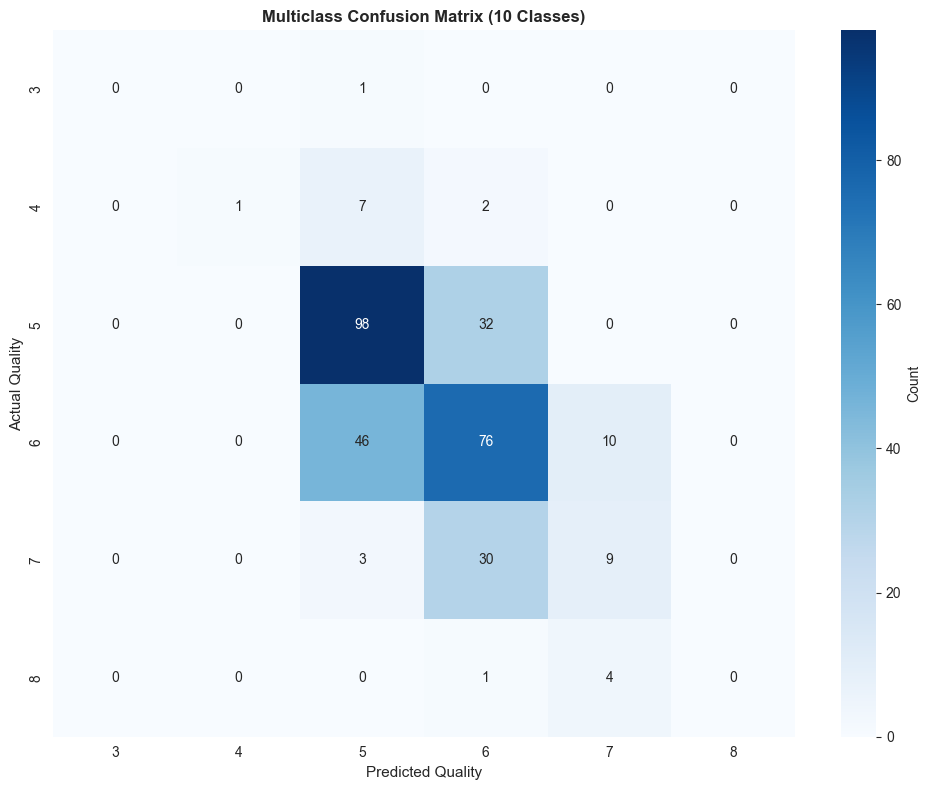

Confusion Matrix Shape: (6, 6)

Note: Diagonal elements = correct predictions
      Off-diagonal = misclassifications


In [16]:
# TODO: Compute confusion matrix for multiclass
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipeline_multiclass.classes_,
            yticklabels=pipeline_multiclass.classes_,
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_ylabel('Actual Quality', fontsize=11)
ax.set_xlabel('Predicted Quality', fontsize=11)
ax.set_title('Multiclass Confusion Matrix (10 Classes)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("Confusion Matrix Shape:", cm_multi.shape)
print(f"\nNote: Diagonal elements = correct predictions")
print(f"      Off-diagonal = misclassifications")

### B.2: Per-Class Metrics

With multiclass problems and imbalance, compute precision/recall/F1 for each class separately.

Classification Report (Multiclass):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       1.00      0.10      0.18        10
           5       0.63      0.75      0.69       130
           6       0.54      0.58      0.56       132
           7       0.39      0.21      0.28        42
           8       0.00      0.00      0.00         5

    accuracy                           0.57       320
   macro avg       0.43      0.27      0.28       320
weighted avg       0.56      0.57      0.55       320



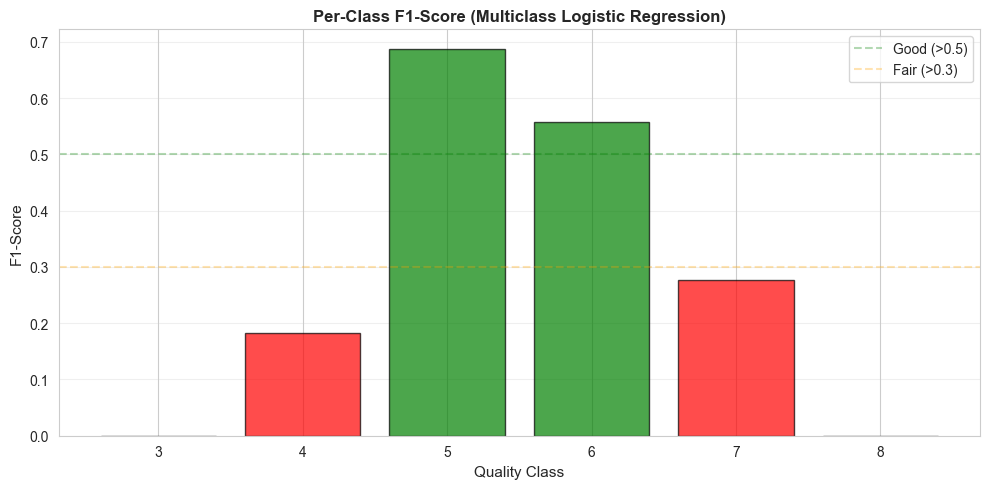


Note: Classes 3 and 4 have low F1-scores due to sparse samples.


In [17]:
# TODO: Use classification_report for detailed per-class metrics
report = classification_report(y_test_multi, y_pred_multi, output_dict=True)

print("Classification Report (Multiclass):")
print(classification_report(y_test_multi, y_pred_multi))

# Visualize per-class F1 scores
classes = [str(int(c)) for c in pipeline_multiclass.classes_]
f1_scores = [report[c]['f1-score'] for c in classes]

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if f > 0.5 else 'orange' if f > 0.3 else 'red' for f in f1_scores]
ax.bar(classes, f1_scores, color=colors, edgecolor='black', alpha=0.7)
ax.set_xlabel('Quality Class', fontsize=11)
ax.set_ylabel('F1-Score', fontsize=11)
ax.set_title('Per-Class F1-Score (Multiclass Logistic Regression)', fontsize=12, fontweight='bold')
ax.axhline(y=0.5, color='green', linestyle='--', alpha=0.3, label='Good (>0.5)')
ax.axhline(y=0.3, color='orange', linestyle='--', alpha=0.3, label='Fair (>0.3)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNote: Classes 3 and 4 have low F1-scores due to sparse samples.")

### B.3: One-vs-Rest Alternative

Multinomial logistic regression solves one optimization problem with 10 classes. One-vs-Rest (OvR) trains 10 separate binary classifiers.

In [20]:
# TODO: Train logistic regression with One-vs-Rest strategy
pipeline_ovr = Pipeline([
    ('scaler', StandardScaler()),
    ('ovr', OneVsRestClassifier(
        LogisticRegression(random_state=42, max_iter=1000)
    ))
])

pipeline_ovr.fit(X_train_multi, y_train_multi)

y_pred_ovr = pipeline_ovr.predict(X_test_multi)
acc_ovr = accuracy_score(y_test_multi, y_pred_ovr)

print("Multiclass Logistic Regression Comparison:")
print(f"\n  Multinomial (single optimization):")
print(f"    Test Accuracy: {acc_multi:.4f}")
print(f"\n  One-vs-Rest (6 binary classifiers):")
print(f"    Test Accuracy: {acc_ovr:.4f}")
print(f"\n  Difference: {abs(acc_multi - acc_ovr):.4f}")
print(f"\nNote: OvR trains separate binary classifier for each class.")
print(f"      Multinomial optimizes all classes jointly.")

Multiclass Logistic Regression Comparison:

  Multinomial (single optimization):
    Test Accuracy: 0.5750

  One-vs-Rest (6 binary classifiers):
    Test Accuracy: 0.5656

  Difference: 0.0094

Note: OvR trains separate binary classifier for each class.
      Multinomial optimizes all classes jointly.


## Part C: Algorithm Comparison (KNN, LDA, Naive Bayes)

Now we'll quickly instantiate three algorithms from the lectures on the 10-class problem:
- **KNN** (Part 2): Non-parametric, instance-based
- **LDA** (Part 3): Generative, linear decision boundaries
- **Naive Bayes** (Part 3): Generative, probabilistic

Then compare accuracy with multinomial logistic regression.

### C.1: K-Nearest Neighbors

In [21]:
# TODO: Instantiate KNeighborsClassifier with n_neighbors=5
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

pipeline_knn.fit(X_train_multi, y_train_multi)
y_pred_knn = pipeline_knn.predict(X_test_multi)
acc_knn = accuracy_score(y_test_multi, y_pred_knn)

print(f"K-Nearest Neighbors (K=5):")
print(f"  Test Accuracy: {acc_knn:.4f}")

K-Nearest Neighbors (K=5):
  Test Accuracy: 0.5469


### C.2: Linear Discriminant Analysis

In [22]:
# TODO: Instantiate LinearDiscriminantAnalysis
pipeline_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

pipeline_lda.fit(X_train_multi, y_train_multi)
y_pred_lda = pipeline_lda.predict(X_test_multi)
acc_lda = accuracy_score(y_test_multi, y_pred_lda)

print(f"Linear Discriminant Analysis:")
print(f"  Test Accuracy: {acc_lda:.4f}")

Linear Discriminant Analysis:
  Test Accuracy: 0.5594


### C.3: Gaussian Naive Bayes

In [23]:
# TODO: Instantiate GaussianNB
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

pipeline_nb.fit(X_train_multi, y_train_multi)
y_pred_nb = pipeline_nb.predict(X_test_multi)
acc_nb = accuracy_score(y_test_multi, y_pred_nb)

print(f"Gaussian Naive Bayes:")
print(f"  Test Accuracy: {acc_nb:.4f}")

Gaussian Naive Bayes:
  Test Accuracy: 0.5469


### C.4: Support Vector Classifier (SVC)

In [24]:
# TODO: Instantiate SVC with RBF kernel
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', random_state=42))
])

pipeline_svc.fit(X_train_multi, y_train_multi)
y_pred_svc = pipeline_svc.predict(X_test_multi)
acc_svc = accuracy_score(y_test_multi, y_pred_svc)

print(f"Support Vector Classifier (RBF kernel):")
print(f"  Test Accuracy: {acc_svc:.4f}")
print(f"\nNote: SVC with RBF kernel can capture non-linear decision boundaries.")

Support Vector Classifier (RBF kernel):
  Test Accuracy: 0.6031

Note: SVC with RBF kernel can capture non-linear decision boundaries.



MULTICLASS CLASSIFICATION - ALGORITHM COMPARISON
          Algorithm  Test Accuracy
          SVC (RBF)       0.603125
Logistic Regression       0.575000
                LDA       0.559375
          KNN (K=5)       0.546875
        Naive Bayes       0.546875


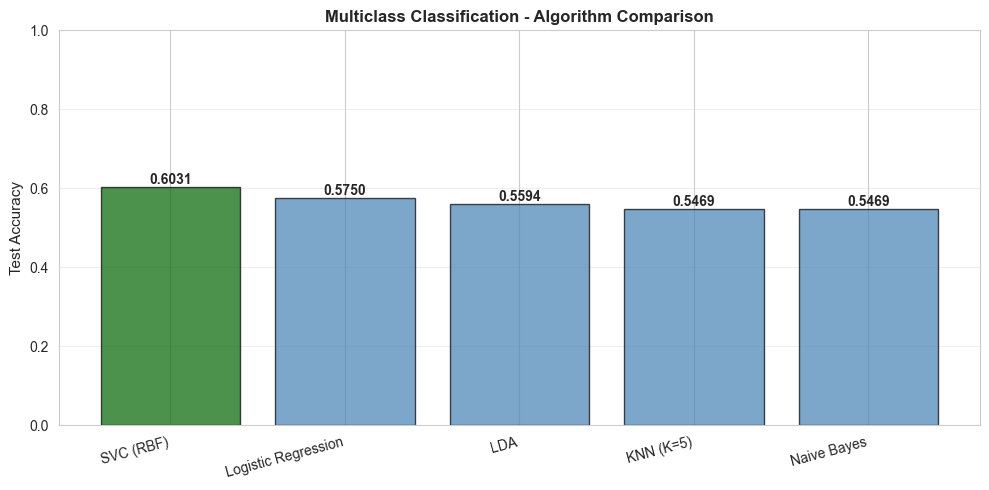


✓ Best performing algorithm: SVC (RBF)
  Accuracy: 0.6031


In [25]:
# Demo: Compare all algorithms
comparison_df = pd.DataFrame({
    'Algorithm': ['Logistic Regression', 'SVC (RBF)', 'LDA', 'KNN (K=5)', 'Naive Bayes'],
    'Test Accuracy': [acc_multi, acc_svc, acc_lda, acc_knn, acc_nb]
}).sort_values('Test Accuracy', ascending=False)

print("\n" + "="*60)
print("MULTICLASS CLASSIFICATION - ALGORITHM COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['steelblue' if acc != comparison_df['Test Accuracy'].max() else 'darkgreen' 
          for acc in comparison_df['Test Accuracy']]
bars = ax.bar(comparison_df['Algorithm'], comparison_df['Test Accuracy'], 
              color=colors, edgecolor='black', alpha=0.7)

ax.set_ylabel('Test Accuracy', fontsize=11)
ax.set_title('Multiclass Classification - Algorithm Comparison', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print(f"\n✓ Best performing algorithm: {comparison_df.iloc[0]['Algorithm']}")
print(f"  Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")

### C.5: Sample Confusion Matrix (Best Algorithm)

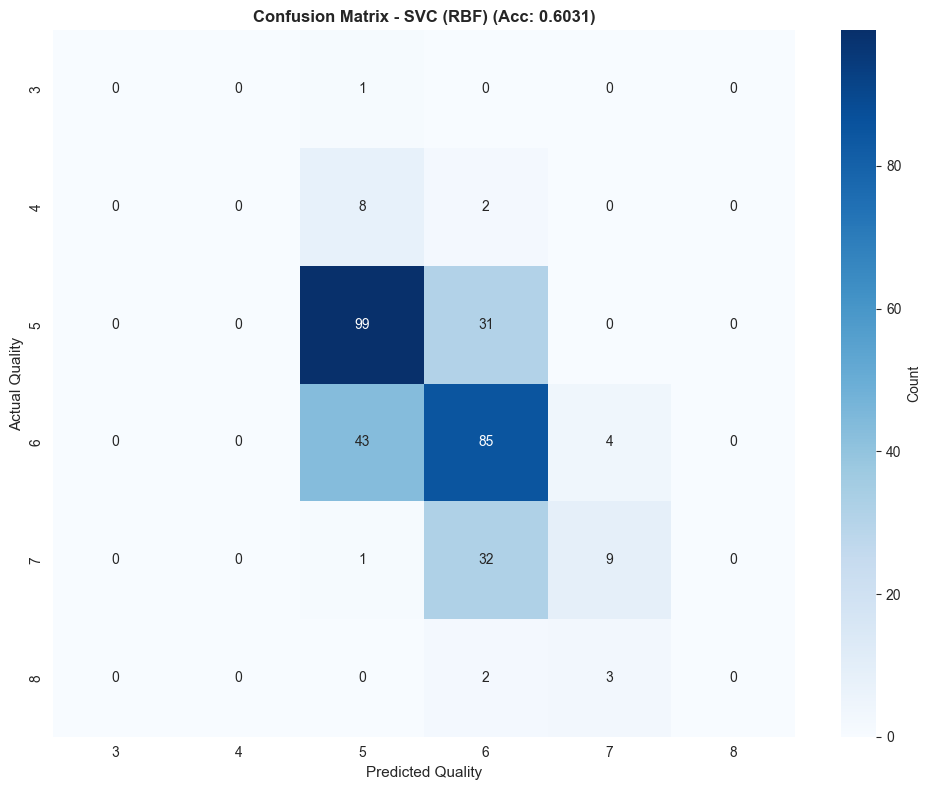

In [26]:
# Demo: Show confusion matrix for best algorithm
best_algo = comparison_df.iloc[0]['Algorithm']
best_acc = comparison_df.iloc[0]['Test Accuracy']

if best_algo == 'Logistic Regression':
    y_pred_best = y_pred_multi
elif best_algo == 'SVC (RBF)':
    y_pred_best = y_pred_svc
elif best_algo == 'KNN (K=5)':
    y_pred_best = y_pred_knn
elif best_algo == 'LDA':
    y_pred_best = y_pred_lda
else:
    y_pred_best = y_pred_nb

cm_best = confusion_matrix(y_test_multi, y_pred_best)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipeline_multiclass.classes_,
            yticklabels=pipeline_multiclass.classes_,
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_ylabel('Actual Quality', fontsize=11)
ax.set_xlabel('Predicted Quality', fontsize=11)
ax.set_title(f'Confusion Matrix - {best_algo} (Acc: {best_acc:.4f})', 
            fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary & Takeaways

**Part A (Binary Classification)**:
- Logistic regression maps predictions to [0, 1] using sigmoid function
- Decision threshold determines precision-recall tradeoff
- Confusion matrix shows false positives vs false negatives

**Part B (Multiclass Classification)**:
- Softmax extends sigmoid to K classes
- Multinomial logistic regression solves single optimization problem
- One-vs-Rest trains K binary classifiers (similar results for logistic)
- Class imbalance makes simple accuracy unreliable

**Part C (Algorithm Comparison)**:
- Multiple algorithms can solve the same problem with different tradeoffs
- **Logistic Regression**: Interpretable, probabilistic, fast
- **KNN**: Simple, flexible, slow for large datasets
- **LDA**: Linear boundaries, assumes Gaussian class distributions
- **Naive Bayes**: Strong assumption but good with high dimensions or missing data

**Key Insight**: No single algorithm dominates; choice depends on:
- Interpretability requirements
- Computational budget
- Data characteristics (balanced? missing values?)
- Deployment constraints